In [138]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from xml.dom import minidom
import requests
import xml.etree.ElementTree as ET
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib
import matplotlib.pyplot as plt

In [139]:
file_name = '/content/Sample-XML.xml'

In [140]:
def ExtractDataFromXML(file_name):
    path = file_name
    dfcols = ['title', 'link', 'description','pubDate', 'articleid', 'website', 'issue', 'type', 'showcase']
    root = ET.parse(path)
    rows = root.findall('./channel/item')
    xml_data =[]
    for row in rows:
        first_data = []
        for col in dfcols:
            try:
                first_data.append(row.find(col).text)
            except AttributeError:
                first_data.append('No values')
        xml_data.append(first_data)
    df_xml = pd.DataFrame(xml_data, columns=dfcols)
    return df_xml

In [141]:
def missing_data(df):

    df.drop(df[df['description'] == 'No values'].index,inplace = True)
    return df.reset_index(drop = True)

In [142]:
def basic_details(df):
    print("-"*50)
    print(df.shape)
    print("-"*50)
    print(df.columns)
    print("-"*50)
    print(df.dtypes)

In [143]:
print('----Actual data------')
df_xml = ExtractDataFromXML(file_name)
print('-----------baisc details----------------')
basic_details(df_xml)
print("="*100)
print(df_xml.head())
print("="*100)
print(df_xml.head())
print('-----droping extra columns----------')
df_xml.drop(['link','pubDate','articleid','website','type','showcase'],axis = 1, inplace = True)
print('------missing data handling-----------')
missing_dropped_df = missing_data(df_xml)
missing_dropped_df.to_csv('/content/data-XML.csv',index= False)
print(missing_dropped_df.head())
print("="*100)
print(missing_dropped_df.tail())

----Actual data------
-----------baisc details----------------
--------------------------------------------------
(500, 9)
--------------------------------------------------
Index(['title', 'link', 'description', 'pubDate', 'articleid', 'website',
       'issue', 'type', 'showcase'],
      dtype='object')
--------------------------------------------------
title          object
link           object
description    object
pubDate        object
articleid      object
website        object
issue          object
type           object
showcase       object
dtype: object
                                               title  ... showcase
0  No Duty on Chinese Imports for Public Solar Po...  ...       NO
1   Solar Tariffs Fall to Record Low of Rs 2.36/Unit  ...       NO
2                  Corning appoints new MD for India  ...       NO
3  L&T Makes Key Component for Advanced Nuclear R...  ...       NO
4  Two percent discount on lump sum payment of el...  ...       NO

[5 rows x 9 columns]
      

In [144]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [145]:
def decontracted(phrase):
    phrase = [word for word in phrase.split() if len(word) > 3]
    phrase = ' '.join(phrase)
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = phrase.replace('\\r', ' ')
    phrase = phrase.replace('\\n', ' ')
    phrase = phrase.replace('\\"', ' ')
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase= ' '.join(e for e in phrase.split() if e.lower() not in stopwords)
    return phrase


In [146]:
def data_cleaning(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x : decontracted(str(x)))
    return df

In [147]:
print("="*10 +'Data cleaning started' +"="*10)
cleaned_df = data_cleaning(missing_dropped_df)
print(cleaned_df.head())
print(cleaned_df.shape)

==========Data cleaning started==========
                                               title  ...                                          issue
0  Duty Chinese Imports Public Solar Power Projec...  ...  Ministry Renewable Energy Ministry Power MNRE
1                Solar Tariffs Fall Record 2 36 Unit  ...                      Ministry Renewable Energy
2                             Corning appoints India  ...                                      Honeywell
3           Makes Component Advanced Nuclear Reactor  ...                                L Larsen Toubro
4  MERC directs power discoms make billing transp...  ...                                 Power Minister

[5 rows x 3 columns]
(492, 3)


In [148]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [149]:
def tokenize_and_stem(text):
    stemmer = SnowballStemmer("english")
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = ' '.join(stems)
    return stems


In [150]:
def tokenized_data(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: tokenize_and_stem(x))
    return df

In [151]:
print("="*10 + "tpkenization started" +"="*10)
tokenized_df = tokenized_data(cleaned_df)
print(f"tokenized_df shape:{tokenized_df.shape}")
print(tokenized_df.head())

==========tpkenization started==========
tokenized_df shape:(492, 3)
                                               title  ...                                      issue
0  duti chines import public solar power project ...  ...  ministri renew energi ministri power mnre
1                      solar tariff fall record unit  ...                      ministri renew energi
2                                 corn appoint india  ...                                   honeywel
3                 make compon advanc nuclear reactor  ...                            l larsen toubro
4        merc direct power discom make bill transpar  ...                               power minist

[5 rows x 3 columns]


In [152]:
def Tf_idf(text):
    vectorizer = TfidfVectorizer(min_df = 20)
    text_tfidf = vectorizer.fit_transform(text)
    print("Shape of matrix after one hot encodig ",text_tfidf.shape)
    return text_tfidf

In [153]:
print('-----------vectorizing the data-----------')
title = tokenized_df['title'].values
description = tokenized_df['description'].values
issue = tokenized_df['issue'].values
print("="*100)
title_tfidf = Tf_idf(title)
description_tfidf = Tf_idf(description)
issue_tfidf = Tf_idf(issue)


-----------vectorizing the data-----------
Shape of matrix after one hot encodig  (492, 18)
Shape of matrix after one hot encodig  (492, 1010)
Shape of matrix after one hot encodig  (492, 9)


In [154]:
final_dataset = hstack((title_tfidf, description_tfidf,issue_tfidf)).tocsr()
print(f"final_dataset shape:{final_dataset.shape}")
print('---------cosine similarity--------------')

final_dataset shape:(492, 1037)
---------cosine similarity--------------


In [155]:
def finding_optimalK(data_transformed):
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data_transformed)
        Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

-----finding optimal k-----------


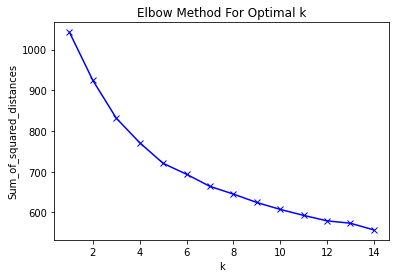

In [156]:
print('-----finding optimal k-----------')
finding_optimalK(final_dataset)

In [157]:
print('-------optimal k = 7 -----------')
num_clusters = 7
km = KMeans(n_clusters=num_clusters,random_state= 42)
km.fit(final_dataset)
joblib.dump(km,'/content/kognoz_cluster.pkl')
data_pkl = joblib.load('/content/kognoz_cluster.pkl')
clusters = data_pkl.labels_.tolist()
print(clusters)
updated_df = missing_dropped_df.copy()
updated_df['clusters'] = clusters


-------optimal k = 7 -----------
[4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 5, 5, 0, 2, 4, 4, 0, 2, 5, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 5, 0, 2, 2, 2, 4, 5, 6, 0, 2, 6, 2, 0, 2, 1, 0, 4, 2, 1, 5, 0, 2, 0, 0, 5, 4, 5, 5, 2, 0, 2, 0, 0, 5, 5, 2, 2, 5, 5, 0, 5, 1, 0, 1, 1, 4, 1, 5, 4, 4, 0, 5, 1, 0, 4, 2, 5, 5, 1, 5, 6, 5, 4, 1, 4, 1, 4, 5, 4, 5, 0, 0, 2, 2, 2, 0, 0, 4, 0, 4, 2, 0, 4, 5, 5, 4, 2, 5, 0, 1, 4, 5, 2, 4, 5, 5, 4, 1, 0, 6, 5, 6, 0, 1, 1, 0, 6, 1, 2, 1, 0, 1, 6, 6, 0, 6, 5, 5, 4, 2, 0, 1, 4, 6, 6, 2, 5, 0, 5, 2, 0, 5, 0, 1, 0, 2, 4, 6, 4, 0, 0, 0, 2, 4, 1, 0, 1, 2, 2, 2, 2, 6, 6, 6, 2, 6, 0, 2, 0, 0, 1, 2, 2, 1, 0, 4, 5, 1, 0, 6, 0, 5, 1, 0, 0, 1, 6, 1, 0, 0, 4, 1, 6, 6, 2, 2, 5, 1, 0, 1, 1, 0, 6, 6, 1, 6, 0, 5, 5, 6, 2, 6, 5, 2, 2, 6, 6, 1, 2, 6, 6, 0, 4, 6, 2, 4, 0, 0, 6, 4, 0, 5, 6, 6, 0, 6, 4, 5, 4, 2, 1, 4, 0, 0, 5, 0, 2, 4, 5, 5, 1, 2, 1, 6, 2, 2, 4, 2, 0, 0, 0, 1, 6, 6, 0, 6, 1, 5, 0, 4, 2, 0, 4, 2, 1, 0, 2, 4, 1, 5, 0, 4, 0, 5, 5, 0, 4, 0, 0, 1, 4, 0, 

In [158]:
len(clusters)

492

In [159]:
updated_df.to_csv('/content/data_clustered_1st.csv',index= False)

In [135]:
print(updated_df.tail(10))

                                                 title  ... clusters
490                        yeblikksbild siden slik gmt  ...        2
491  book samsung engin unknown ongc offici collud ...  ...        2
492           cr capex plan aurangabad hyderabad plant  ...        5
493  neyv power plant explos tamil nadu amit shah c...  ...        6
494  neyv power plant explos tamil nadu amit shah c...  ...        6
495      canada covid relief saskatchewan mine compani  ...        5
496         boiler explos amit shah assur possibl help  ...        6
497         boiler explos amit shah assur possibl help  ...        6
498  tamil nadu lost live injur boiler explos power...  ...        6
499                            invest india plung year  ...        5

[10 rows x 4 columns]


In [136]:
print(updated_df.head(10))

                                               title  ... clusters
0  duti chines import public solar power project ...  ...        1
1                      solar tariff fall record unit  ...        5
2                                 corn appoint india  ...        5
3                 make compon advanc nuclear reactor  ...        5
4          percent discount lump payment electr bill  ...        1
5                     increas electr payment postpon  ...        1
6        merc direct power discom make bill transpar  ...        1
7      flag final assembl cryostat bn fusion reactor  ...        5
8               corpor make energi wast wealth plant  ...        1
9        okhla landfil chum power sdmc ink pact ntpc  ...        1

[10 rows x 4 columns]


In [111]:
len(clusters)

500

In [160]:
def cluster_naming(c):
    if c == 0:
        return 'Customers News'
    if c == 1:
        return "General Industry news"
    if c == 2:
        return "Niti Aayog"
    if c == 3:
        return "Power Industry News"
    if c == 4:
        return "Ministry of New and Renewable Energy,MNRE"
    if c == 5:
        return "Electric Vehicles"
    if c == 6:
        return "Stock market"

In [161]:
updated_df['News type'] = updated_df['clusters'].apply(lambda x : cluster_naming(x))

In [162]:
updated_df.to_csv('/content/data_clustered.csv',index= False)

In [163]:
print(updated_df.head())
print("="*100)
print(updated_df.tail())

                                               title  ...                                  News type
0  duti chines import public solar power project ...  ...  Ministry of New and Renewable Energy,MNRE
1                      solar tariff fall record unit  ...  Ministry of New and Renewable Energy,MNRE
2                                 corn appoint india  ...                                 Niti Aayog
3                 make compon advanc nuclear reactor  ...  Ministry of New and Renewable Energy,MNRE
4        merc direct power discom make bill transpar  ...  Ministry of New and Renewable Energy,MNRE

[5 rows x 5 columns]
                                                 title  ...              News type
487      canada covid relief saskatchewan mine compani  ...  General Industry news
488         boiler explos amit shah assur possibl help  ...    Power Industry News
489         boiler explos amit shah assur possibl help  ...    Power Industry News
490  tamil nadu lost live injur boiler e

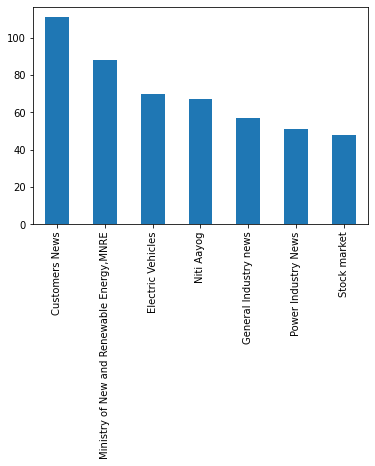

In [164]:
updated_df['News type'].value_counts().plot.bar()